# Exercise 5: Simple Data Exploration
## Geographic Information Systems 1 Lab
### GEOG 3150

Remember to begin each exercise by creating a copy of this _colab notebook_ by going to **File > Save a copy in Drive**. Once you have a copy, go to **Runtime > Run all** to make sure you are connected and each cell of the exercise has been executed. If necessary, refer back to the [Exercise 2 Notebook](https://githubtocolab.com/chrismgentry/GIS1-Exercise-2/blob/main/GIS1_EX2.ipynb) for a refresher on how to work with **text cells**, **code cells**, and using the **Share** button at the top of the page. 

# Information

#### Before beginning the exercise be sure to thoroughly read the the exercise page on [GitHub](https://chrismgentry.github.io/GIS1-Exercise-5). This will provide additional information not covered in this notebook. It would be beneficial to have both windows open so you can refer back to the exercise at any time while working on this notebook. Throughout this notebook there will be various code cells and text cells you may need to edit. Simply double-click on the cell to open it for editing.

Atypical information regarding the _ggsn package_:<br>
"Due to a dependency issue, the following script had to be used to ensure that the _ggsn_ package would load correctly for this exercise."

In [1]:
system('sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable')
system('sudo apt-get update')
system('sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev')

# Step One: The Data
The datasets used in this exercise will be found on the [Exercise 5](https://github.com/chrismgentry/GIS1-Exercise-5) Github Page, previous exercises such as [Exercise 2](https://github.com/chrismgentry/GIS1-Exercise-2) and [Exercise 3](https://github.com/chrismgentry/GIS1-Exercise-3), and also from the [Tennessee Geographic Information Council](http://www.tngis.org/data-collections.htm). TN GIS maintains a number of datasets in their collections that are useful for projects involving the state of Tennessee.

### Installing and loading packages
Note: In previous exercises you have installed and loaded packages individually. While this makes sense when you are first learning to use R, many project require a large number of packages and will take a while to load. So for this exercise you will learn how to create a list of package names, install them, and load the libraries all within three lines of code. In later exercises you will learn how to use a library management package to install and load libraries.

In [2]:
packages<-c('googledrive','tidyverse','ggsn','cowplot','maps','mapproj','raster','rgeos','rgdal','sp','sf','biscale')
sapply(packages, install.packages, character.only = TRUE)
sapply(packages, require, character.only = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’, ‘sp’, ‘RgoogleMaps’, ‘plyr’, ‘rjson’, ‘jpeg’, ‘bitops’, ‘sf’, ‘png’, ‘maptools’, ‘ggmap’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecifi

$googledrive
NULL

$tidyverse
NULL

$ggsn
NULL

$cowplot
NULL

$maps
NULL

$mapproj
NULL

$raster
NULL

$rgeos
NULL

$rgdal
NULL

$sp
NULL

$sf
NULL

$biscale
NULL

Loading required package: googledrive

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: ggsn

Loading required package: grid

Loading required package: cowplot

Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map


Loading required package: mapproj

Loading required package: raster

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:ggsn’:

    scalebar


The following 

googledrive   tidyverse        ggsn     cowplot        maps     mapproj 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
     raster       rgeos       rgdal          sp          sf     biscale 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE

As you saw in [Exercise 3](https://chrismgentry.github.io/GIS1-Exercise-3/), the [tigris package](https://cran.r-project.org/web/packages/tigris/index.html) provides access to _Topologically Integrated Geographic Encoding and Referencing_ (TIGER) data from the U.S. Census Bureau. However the package needs to be loaded separately from the other packages.

In [3]:
devtools::install_github('walkerke/tigris')
library('tigris')

tibble  (3.1.3 -> 3.1.4) [CRAN]
openssl (1.4.3 -> 1.4.4) [CRAN]
stringi (1.7.3 -> 1.7.4) [CRAN]


Installing 3 packages: tibble, openssl, stringi

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpYpdxdU/remotes40eeccb5f/walkerke-tigris-cb4dee8/DESCRIPTION’
─  preparing ‘tigris’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘tigris_1.4.1.9000.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

To enable 
caching of data, set `options(tigris_use_cache = TRUE)` in your R script or .Rprofile.



While some of the data for this exercise you will obtain from previous exercises, you will start this lab by downloading a dataset from TN GIS. While they maintain a number of quality collections, you will specifically download the statewide watershed coverage (12 digit Hydrologic Unit Code) for Tennessee. This information can be found at the following link: http://www.tngis.org/water.htm. Because **TN GIS** stores their data in a Google Drive drive folder, the process to download the data varies from what you have previously experienced.

In [4]:
drive_deauth()
drive_download(as_id("0B9UIdGiB_LXOeVVQNm91bGpvUUE"), overwrite = TRUE)
unzip('tn_wbd.zip')
unzip('tn_12dig_huc.zip', exdir = "/content/watersheds")

File downloaded:

• tn_wbd.zip <id: 0B9UIdGiB_LXOeVVQNm91bGpvUUE>

Saved locally as:

• tn_wbd.zip



Due to the file structure of the file, the uncompressed data contains unusable file names. Therefore you must obtain a list of the names for ease of renaming.

In [5]:
names <- list.files(path = "/content/watersheds", pattern = "hydrologic_units")
names

[1] "hydrologic_units\\gway_959558_01_WBDHU12.txt"
 [2] "hydrologic_units\\wbd_state_metadata.html"   
 [3] "hydrologic_units\\wbddoc_readme.txt"         
 [4] "hydrologic_units\\wbddoc_user_guide.doc"     
 [5] "hydrologic_units\\wbdhu12_a_tn.dbf"          
 [6] "hydrologic_units\\wbdhu12_a_tn.prj"          
 [7] "hydrologic_units\\wbdhu12_a_tn.sbn"          
 [8] "hydrologic_units\\wbdhu12_a_tn.sbx"          
 [9] "hydrologic_units\\wbdhu12_a_tn.shp"          
[10] "hydrologic_units\\wbdhu12_a_tn.shx"          
[11] "hydrologic_units\\wbdhu12_l_tn.dbf"          
[12] "hydrologic_units\\wbdhu12_l_tn.prj"          
[13] "hydrologic_units\\wbdhu12_l_tn.sbn"          
[14] "hydrologic_units\\wbdhu12_l_tn.sbx"          
[15] "hydrologic_units\\wbdhu12_l_tn.shp"          
[16] "hydrologic_units\\wbdhu12_l_tn.shx"

By examining the names above, you can see the first 17 characters are unnecessary. So you will use the script below to create new names that remove that portion. 

In [6]:
new_names <- sub('.................','',names)
new_names

[1] "gway_959558_01_WBDHU12.txt" "wbd_state_metadata.html"   
 [3] "wbddoc_readme.txt"          "wbddoc_user_guide.doc"     
 [5] "wbdhu12_a_tn.dbf"           "wbdhu12_a_tn.prj"          
 [7] "wbdhu12_a_tn.sbn"           "wbdhu12_a_tn.sbx"          
 [9] "wbdhu12_a_tn.shp"           "wbdhu12_a_tn.shx"          
[11] "wbdhu12_l_tn.dbf"           "wbdhu12_l_tn.prj"          
[13] "wbdhu12_l_tn.sbn"           "wbdhu12_l_tn.sbx"          
[15] "wbdhu12_l_tn.shp"           "wbdhu12_l_tn.shx"

Because file.rename operates at the root directory level, you need to temporarily direct the working directory to the location of the inappropriately named files, rename them, then return to the correct working directory.

In [7]:
setwd("/content/watersheds")
file.rename(names,new_names)
setwd("/content")

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE

Now you can use `readOGR` to read the shapefiles to a new object.

In [8]:
watersheds_data <- readOGR("/content/watersheds/wbdhu12_a_tn.shp")

OGR data source with driver: ESRI Shapefile 
Source: "/content/watersheds/wbdhu12_a_tn.shp", layer: "wbdhu12_a_tn"
with 1953 features
It has 17 fields


Similar to previous exercises, in this step you will download data from the exercises [GitHub Reporistory](https://github.com/chrismgentry/GIS1-Exercise-5), unzip the data, and create a new object using `readOGR`.

In [9]:
download.file('https://github.com/chrismgentry/GIS1-Exercise-5/raw/main/Data/brownfields.zip', 'brownfields.zip')
unzip('brownfields.zip', exdir = "/content/brownfields")
brownfields_data <- readOGR("/content/brownfields/brownfields.shp")

OGR data source with driver: ESRI Shapefile 
Source: "/content/brownfields/brownfields.shp", layer: "brownfields"
with 25703 features
It has 1 fields


Now you need to create an object for the demographic data using `read.csv`.

In [10]:
demographics <- read.csv('https://raw.githubusercontent.com/chrismgentry/GIS1-Exercise-5/main/Data/demographics.csv')

Using the _tigris package_ you will use the `tracts` command to obtain census tracts for Montgomery County, Tennessee. Remember from [Exercise 3](https://chrismgentry.github.io/GIS1-Exercise-3/) data from _tigris_ is formatted as **simple features** and therefore will be treated differently than other objects in certain scripts.

In [11]:
montco_tracts <- tracts("TN", county = "Montgomery")

  |======================================================================| 100%


With objects created for the census tracts, watersheds, and brownfields datasets, you need to examine the projection information to ensure they are all in the same coordinate reference system (crs).

In [12]:
crs(watersheds_data)
crs(brownfields_data)
crs(montco_tracts)

CRS arguments:
 +proj=lcc +lat_0=34.3333333333333 +lon_0=-86 +lat_1=36.4166666666667
+lat_2=35.25 +x_0=600000 +y_0=0 +datum=NAD83 +units=m +no_defs 

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

CRS arguments: +proj=longlat +datum=NAD83 +no_defs 

You can see that each of the three datasets are in different projections. Therefore you need to reproject them under a single CRS. For this exercise you will use [EPSG:4326](https://epsg.io/4326) which in R appears as `+proj=longlat +datum=WGS84 +no_defs` when referenced in the script. Because the brownfields data is already in this crs you can use it or the EPSG to correct the other datasets

First you will adjust the watersheds data to match the brownfields crs.

In [13]:
watersheds_data <- spTransform(watersheds_data, crs(brownfields_data))
crs(watersheds_data)

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

Next you will adjust the census tract dataset.

In [14]:
montco_tracts <- st_transform(montco_tracts, 4326)
crs(montco_tracts)

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

## **Question No. 1**
Using the **files** button on the left, examine the dataset contained in the brownfields.zip file and answer the following question:<br>
What is the common name of the extracted files? How many are there? What are the various file extensions?

### **ANSWER**:

# Step Two: The Analyses
The data collected in the previous section requires additional processing so you can reduce the dataset to only the pertinent information for the analyses. In this step you will use additional geoprocessing techniques and data management tools to link two datasets for further examination.

Because R operates differently than GUI GIS systems, it is more important to consider the order of operations for a given project. So here you will connect the demographics data to the census tracts although it will not be used until later in the exercise.

In [15]:
census_tracts <- merge(x = montco_tracts, y = demographics, by.x = "NAME", by.y = "Tract", all = TRUE)

If you examined the datasets for brownfields or watersheds using `ggplot2` you would see the extend well beyong the boundaries of Montgomery County. Therefore you will want to crop the datasets to only the same bounding rectangle as the county.

In [16]:
montco_brownfields <- crop(brownfields_data,census_tracts)
montco_watersheds <- crop(watersheds_data,census_tracts)

As _order of operation_ was discussed previously, in a later step you will use the count of brownfields within a tract or watershed to examine their impacts on the community. However, this is a step you will need to complete here.

In [17]:
brownfields_per_watershed <- over(montco_brownfields,montco_watersheds)
watershed_table <- as.data.frame(table(brownfields_per_watershed$HUC_12))
watershed_table <- transform(watershed_table, Var1 = as.character(Var1))
colnames(watershed_table) <- c("HUC_12","BF_Count")
watershed_table

HUC_12,BF_Count
<chr>,<int>
051302050104,1
051302050301,1
051302050305,1
051302050307,1
051302050308,1
051302060404,2
051302060406,1
051302060603,11
051302060707,15


Here you will connect the table back to the watershed dataset for the county. Because some watersheds do not have any brownfields, there will be several NA values in the table. These cause issues when running analyses so you will see script below that removes NA values and replaces them with zeros.

In [18]:
montco_watershed_data <- merge(x = montco_watersheds, y = watershed_table, by.x = "HUC_12", by.y = "HUC_12", all = TRUE)
montco_watershed_data@data$BF_Count[is.na(montco_watershed_data@data$BF_Count)] <- 0
montco_watershed_data@data

,HUC_12,HUC_8,HUC_10,ACRES,NCONTRB_A,HU_10_GNIS,HU_12_GNIS,HU_10_DS,HU_10_NAME,HU_10_MOD,HU_10_TYPE,HU_12_DS,HU_12_NAME,HU_12_MOD,HU_12_TYPE,META_ID,STATES,BF_Count
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
27,051302060604,05130206,0513020606,50918,0,NA,NA,0513020607,West Fork Red River,KA,S,051302060708,Oak Grove-West Fork Red River,KA,S,KY03,"KY,TN",0
19,051302060401,05130206,0513020604,12480,0,NA,NA,0513020606,Little West Fork Red River,KA,S,051302060402,Dry Fork Creek,KA,S,KY03,"KY,TN",0
20,051302060402,05130206,0513020604,33781,0,NA,NA,0513020606,Little West Fork Red River,KA,S,051302060404,Noahs Spring Branch,KA,S,KY03,"KY,TN",0
22,051302060404,05130206,0513020604,9897,0,NA,NA,0513020606,Little West Fork Red River,KA,S,051302060706,Upper Little West Fork Red River,KA,S,KY03,"KY,TN",2
28,051302060704,05130206,0513020607,12242,0,NA,NA,0513020502,Elk Fork-Red River,KA,S,051302060705,Lower Elk Fork,KA,S,TN01,"KY,TN",0
26,051302060603,05130206,0513020606,51466,0,NA,NA,0513020607,West Fork Red River,KA,S,051302060604,Spring Creek,KA,S,TN01,"KY,TN",11
21,051302060403,05130206,0513020604,32649,0,NA,NA,0513020606,Little West Fork Red River,KA,S,051302060404,Piney Fork,KA,S,TN01,TN,0
29,051302060705,05130206,0513020607,20414,0,NA,NA,0513020503,Elk Fork-Red River,KA,S,051302060707,Sturgeon Creek-Red River,KA,S,TN01,TN,0
24,051302060406,05130206,0513020604,9764,0,NA,NA,0513020606,Little West Fork Red River,KA,S,051302060604,Little West Fork Red River Lower,KA,S,TN01,TN,1


Now you can `fortify` the dataset to make it useable in `ggplot2` and reconnect the data.

In [19]:
montco_watershed_data@data$id <- rownames(montco_watershed_data@data)
watersheds <- fortify(montco_watershed_data, region = "id")
watershed_dataset <- merge(x = watersheds, y = montco_watershed_data@data, by.x = "id", by.y = "id", all = TRUE)
watershed_dataset

id,long,lat,order,hole,piece,group,HUC_12,HUC_8,HUC_10,⋯,HU_10_NAME,HU_10_MOD,HU_10_TYPE,HU_12_DS,HU_12_NAME,HU_12_MOD,HU_12_TYPE,META_ID,STATES,BF_Count
<chr>,<dbl>,<dbl>,<int>,<lgl>,<fct>,<fct>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-87.14246,36.31244,1,FALSE,1,1.1,051302020203,05130202,0513020202,⋯,Sycamore Creek,KA,S,051302020308,Sycamore Creek Lower,KA,S,TN01,TN,0
1,-87.14271,36.31274,2,FALSE,1,1.1,051302020203,05130202,0513020202,⋯,Sycamore Creek,KA,S,051302020308,Sycamore Creek Lower,KA,S,TN01,TN,0
1,-87.14298,36.31293,3,FALSE,1,1.1,051302020203,05130202,0513020202,⋯,Sycamore Creek,KA,S,051302020308,Sycamore Creek Lower,KA,S,TN01,TN,0
1,-87.14352,36.31305,4,FALSE,1,1.1,051302020203,05130202,0513020202,⋯,Sycamore Creek,KA,S,051302020308,Sycamore Creek Lower,KA,S,TN01,TN,0
1,-87.14395,36.31322,5,FALSE,1,1.1,051302020203,05130202,0513020202,⋯,Sycamore Creek,KA,S,051302020308,Sycamore Creek Lower,KA,S,TN01,TN,0
1,-87.14439,36.31336,6,FALSE,1,1.1,051302020203,05130202,0513020202,⋯,Sycamore Creek,KA,S,051302020308,Sycamore Creek Lower,KA,S,TN01,TN,0
1,-87.14472,36.31352,7,FALSE,1,1.1,051302020203,05130202,0513020202,⋯,Sycamore Creek,KA,S,051302020308,Sycamore Creek Lower,KA,S,TN01,TN,0
1,-87.14538,36.31383,8,FALSE,1,1.1,051302020203,05130202,0513020202,⋯,Sycamore Creek,KA,S,051302020308,Sycamore Creek Lower,KA,S,TN01,TN,0
1,-87.14597,36.31417,9,FALSE,1,1.1,051302020203,05130202,0513020202,⋯,Sycamore Creek,KA,S,051302020308,Sycamore Creek Lower,KA,S,TN01,TN,0


You will need to complete a similar process for the census tract data as well. However, because it is an `sf object` the process is slightly different.

In [20]:
census_tracts_spdf <- sf::as_Spatial(census_tracts)
brownfields_per_tract <- over(montco_brownfields,census_tracts_spdf)
census_tract_table <- as.data.frame(table(brownfields_per_tract$NAME))
census_tract_table <- transform(census_tract_table, Var1 = as.character(Var1), Freq = as.numeric(Freq))
colnames(census_tract_table) <- c("Name","BF_Count")
census_tract_table

Name,BF_Count
<chr>,<dbl>
1001,1
1004,1
1008,3
1009,1
1011.02,1
1013.04,1
1014,1
1015,1
1016,1


Now the data can be reconnected and the NAs can be removed.

In [21]:
census_tract_dataset <- merge(x = census_tracts, y = census_tract_table, by.x = "NAME", by.y = "Name", all = TRUE)
census_tract_dataset$BF_Count[is.na(census_tract_dataset$BF_Count)] <- 0
str(census_tract_dataset)

Classes ‘sf’ and 'data.frame':	39 obs. of  22 variables:
 $ NAME                     : chr  "1001" "1002" "1003" "1004" ...
 $ STATEFP                  : chr  "47" "47" "47" "47" ...
 $ COUNTYFP                 : chr  "125" "125" "125" "125" ...
 $ TRACTCE                  : chr  "100100" "100200" "100300" "100400" ...
 $ GEOID                    : chr  "47125100100" "47125100200" "47125100300" "47125100400" ...
 $ NAMELSAD                 : chr  "Census Tract 1001" "Census Tract 1002" "Census Tract 1003" "Census Tract 1004" ...
 $ MTFCC                    : chr  "G5020" "G5020" "G5020" "G5020" ...
 $ FUNCSTAT                 : chr  "S" "S" "S" "S" ...
 $ ALAND                    : num  1210603 2554805 10757537 3871787 7447849 ...
 $ AWATER                   : num  77472 196351 360726 61432 167664 ...
 $ INTPTLAT                 : chr  "+36.5275467" "+36.5152365" "+36.4962685" "+36.5106265" ...
 $ INTPTLON                 : chr  "-087.3558995" "-087.3641748" "-087.3608859" "-087.337094

You will need to create a data frame from the brownfields data and renames the columns to be similar to the other datasets to making poltting easier. When the brownfields were cropped, one record outside of Montgomery County was retained due to the irregular nature of the shape. It was the first record so you will see the script below where it was removed.

In [22]:
brownfields_dataset <- as.data.frame(montco_brownfields)
colnames(brownfields_dataset) <- c("Name", "long", "lat", "NA")
brownfields_dataset <- brownfields_dataset[-1,] #removes the first record which is out of Montgomery County
brownfields_dataset

,Name,long,lat,NA
,<chr>,<dbl>,<dbl>,<dbl>
23330,AKEBONO BRAKE - CLARKSVILLE PLANT,-87.26228,36.58559,0
23331,AMERICAN SNUFF CO LLC,-87.23027,36.62213,0
23332,"AMERICAN SNUFF COMPANY, LLC",-87.34855,36.52846,0
23333,AVANTI CORPORATION,-87.27281,36.59594,0
23334,"AVANTI MANUFACTURING, INC.",-87.27441,36.59552,0
23335,BRIDGESTONE METALPHA USA INCORPORATED,-87.25708,36.59257,0
23336,CLARKSVILLE STP,-87.36951,36.54274,0
23337,CROP PRODUCTION SVCS 678,-87.20537,36.64057,0
23338,"FLORIM USA, INC.",-87.25804,36.60743,0


Finally, you can create an outline of the shape of Montgomery County that could be useful in future visualizations.

In [23]:
counties <- map_data("county")
tn_counties <- subset(counties, region == "tennessee")
montco <- subset(tn_counties, subregion == "montgomery")

## **Questions No. 2**

How many watersheds cover Montgomery County? Although they have been clipped from their original geometry, which watershed is the largest? Which is the smallest?

<small>HINT: View acres in the watershed dataset.</small>

### **ANSWER**:

# Step Three: The Visualization
In this step you will need to examine the spatial distribution of brownfields within the watersheds of Montgomery County and make some qualitative interpretations of potentially impacted urban areas. You will also create graphical displays of your data that includes cartographic elements such as legend, scale bar, north arrow, etc.

Simple script to view the distribution of brownfields across the watersheds.

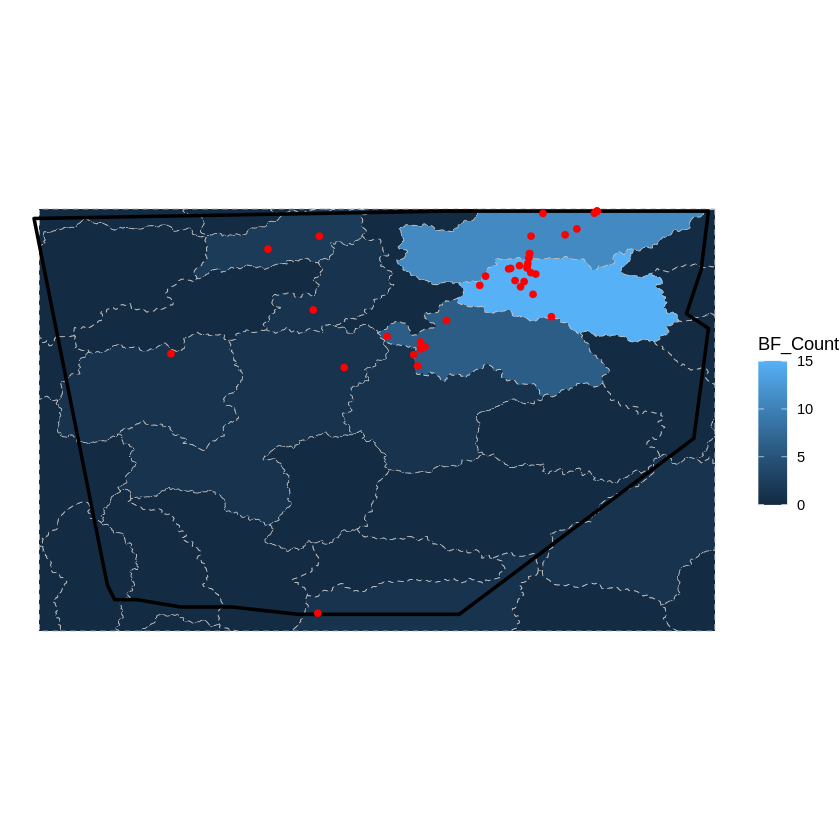

In [24]:
ggplot() +
geom_polygon(data = watershed_dataset, aes(x=long, y=lat, group=group, fill = BF_Count), color = "gray", size = 0.25, linetype="dashed") + 
geom_polygon(data = montco, aes(x=long, y=lat, group=group), fill = NA, color = "black", size = 1) + 
geom_point(data = brownfields_dataset, aes(x=long, y=lat), color = "red") +
coord_fixed() +
theme_void()

Simple script to view the distribution of brownfields across the census tracts. 

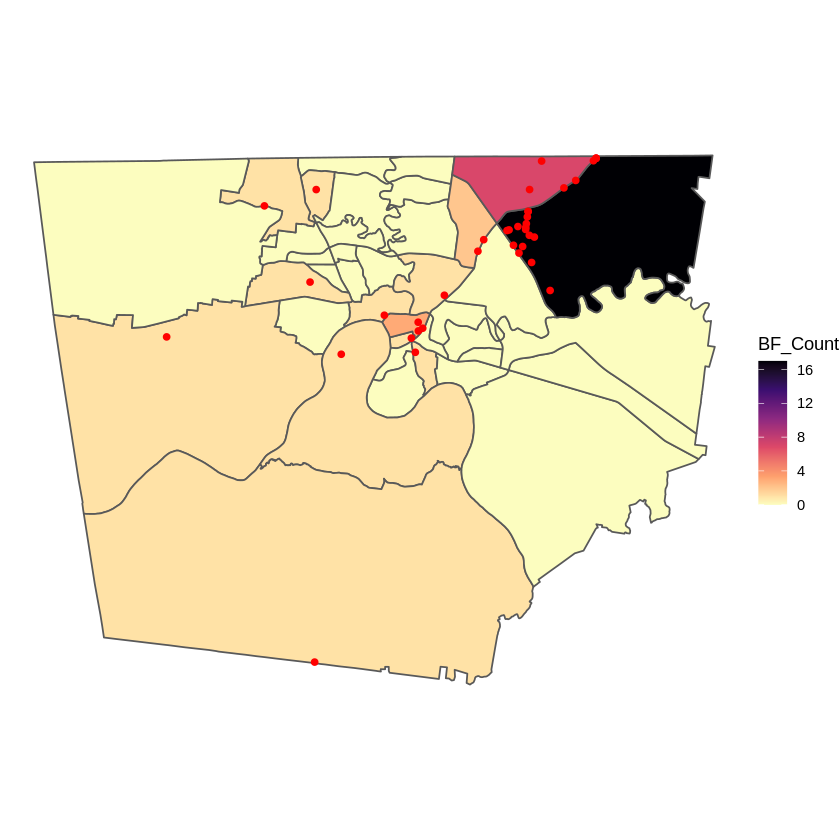

In [25]:
ggplot() +
geom_sf(data = census_tract_dataset, aes(fill = BF_Count)) + scale_fill_viridis_c(direction = -1, option = "A") +
geom_point(data = brownfields_dataset, aes(x=long, y=lat), color = "red") +
coord_sf() +
theme_void()

## **Question No. 3**
Which watershed contains the most brownfields?

### **ANSWER**:

# Step Four: The County Commisson Report
After discussing the results of the previous analysis with your colleagues at County Commission, Stormwater Management, Health Department, and TDEC, they are interested in seeing how the location of brownfields impacts the community demographics.

[Exercise 3](https://github.com/chrismgentry/GIS1-Exercise-3) provided additional population data that is useful for this step.

In [26]:
population <- read.csv('https://raw.githubusercontent.com/chrismgentry/GIS1-Exercise-3/main/Data/mont_co_pop.csv', colClasses=c(Tract="character"))

With this information you can `merge` the population data to the **census_tract_dataset** object created above.

In [27]:
census_with_pop <- merge(x = census_tract_dataset, y = population, by.x = "NAME", by.y = "Tract", all = TRUE)
str(census_with_pop)

Classes ‘sf’ and 'data.frame':	39 obs. of  39 variables:
 $ NAME                     : chr  "1001" "1002" "1003" "1004" ...
 $ STATEFP                  : chr  "47" "47" "47" "47" ...
 $ COUNTYFP                 : chr  "125" "125" "125" "125" ...
 $ TRACTCE                  : chr  "100100" "100200" "100300" "100400" ...
 $ GEOID                    : chr  "47125100100" "47125100200" "47125100300" "47125100400" ...
 $ NAMELSAD                 : chr  "Census Tract 1001" "Census Tract 1002" "Census Tract 1003" "Census Tract 1004" ...
 $ MTFCC                    : chr  "G5020" "G5020" "G5020" "G5020" ...
 $ FUNCSTAT                 : chr  "S" "S" "S" "S" ...
 $ ALAND                    : num  1210603 2554805 10757537 3871787 7447849 ...
 $ AWATER                   : num  77472 196351 360726 61432 167664 ...
 $ INTPTLAT                 : chr  "+36.5275467" "+36.5152365" "+36.4962685" "+36.5106265" ...
 $ INTPTLON                 : chr  "-087.3558995" "-087.3641748" "-087.3608859" "-087.337094

One way you can view two variables at once on a map is to create bivariate symbology.This creates a grid of colors with an X and Y axis with the following categories:
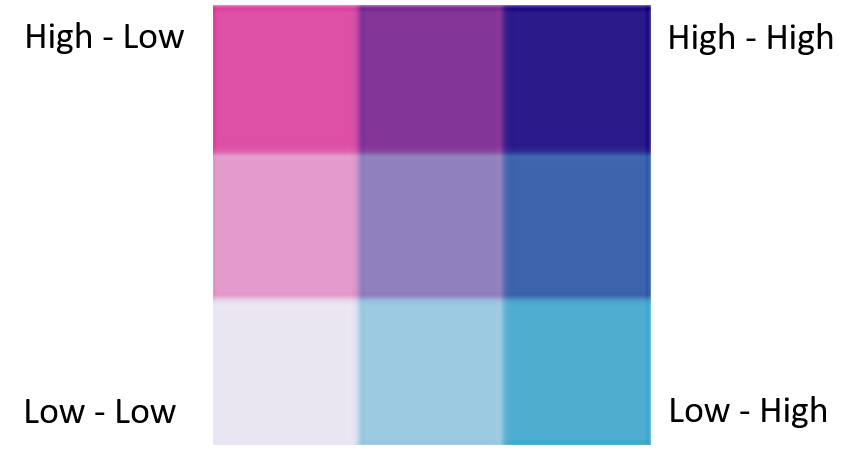
- Where the Bottom Left cell indicates low values in both variables
- Where the Upper Left cell indicates high values in the first variable and low values in the second variable
- Where the Bottom Right cell indicates low values in the first variable and high values in the second variable
- Where the Upper Right cell indicates high values in the first variable and high values in the second variable

Using the `biscale` [package](https://cran.r-project.org/web/packages/biscale/vignettes/biscale.html) you can create quick bivariate maps to visualize this type of data. First you need to create a bivariate dataset using `bi_class`.

In [28]:
bivariate_data <- bi_class(census_with_pop, x = age5_9yo, y = BF_Count, dim = 3, style = "jenks")

Next, using `ggplot2` scripting, you can create the bivariate map.

In [29]:
bivariate_map <- ggplot() +
  geom_sf(data = bivariate_data, mapping = aes(fill = bi_class), color = "white", size = 0.1, show.legend = FALSE) +
  geom_point(data = brownfields_dataset, aes(x=long, y=lat), color = "red") + 
  bi_scale_fill(pal = "DkViolet", dim = 3) +
  theme_void()

Then you will need to use `biscale` scripting for the legend image.

In [30]:
legend <- bi_legend(pal = "DkViolet",
                    dim = 3,
                    xlab = "No. Elementary Age",
                    ylab = "No. Brownfields",
                    size = 10)

And finally, using `cowplot` scripting as you used in the [previous exercise](https://chrismgentry.github.io/GIS1-Exercise-4/#13_Step_Three:_The_Visualization) you can plot the final map.

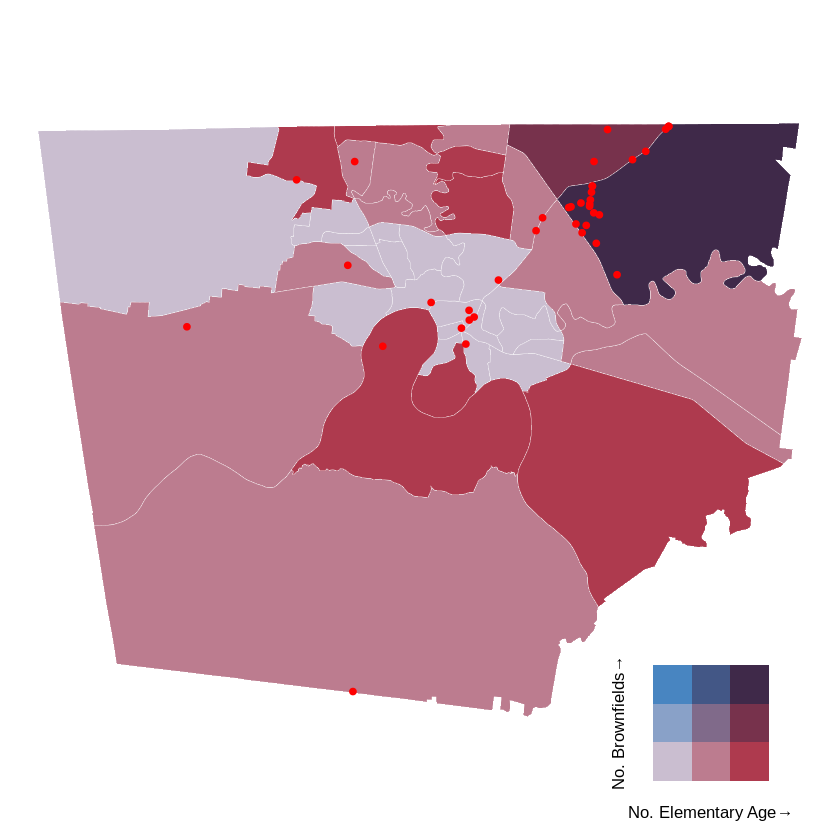

In [31]:
final_map <- ggdraw() +
  draw_plot(bivariate_map, 0, 0, 1, 1) +
  draw_plot(legend, 0.7, 0, 0.25, 0.25)
final_map

## **Question 4**

Which census tract contains the most brownfields?

### **ANSWER**:

# The Write-Up
In the report you provide to the County Commission, Stormwater Management, Health Department, and TDEC please provide the following information:

- Which watershed is most potentially impacted by brownfields?
- What is the total population of the tracts with brownfields?
- What demographic could be the most impacted by brownfields?
 - By examining the tract with the most brownfields, what demographic is the most impacted, and how does it relate to location within the city/county?

When complete, send a link to your Colab Notebook or word document with answers to Questions 1-4 and your completed map from [Step 3](https://chrismgentry.github.io/GIS1-Exercise-5/#13_Step_Three:_The_Visualization) and [Step 4](https://chrismgentry.github.io/GIS1-Exercise-5/#14_Step_Four:_The_County_Commisson_Report) via email.

### **Type write-up here**: